In [1]:
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
import pickle

# Progress bar
from tqdm import tqdm

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import lightgbm as ltb

# Custom classes
import sys
sys.path.insert(0,'..')
from meta_learning import MetaLearner, Model, evaluator
from utils import load_dataset

# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')

## Macros

In [2]:
META_LABEL_METRIC = "precision"
DATASET = "electricity"

BASE_MODEL = RandomForestClassifier
# BASE_MODEL_HYPERPARAMS = {"probability": True}  # SVC
BASE_MODEL_HYPERPARAMS = {"max_depth": 6}  # RandomForest and DecisionTree
# BASE_MODEL_HYPERPARAMS = {}  # Logistic Regression

META_MODEL = ltb.LGBMRegressor
META_MODEL_HYPERPARAMS = {"num_leaves": 21, "max_depth": 5}

FILE_NAME = f"metamodel: {META_MODEL.__name__} - basemodel: {BASE_MODEL.__name__} - metric: {META_LABEL_METRIC} - dataset: {DATASET}"
FILE_NAME

'metamodel: LGBMRegressor - basemodel: RandomForestClassifier - metric: precision - dataset: electricity'

In [3]:
# Macros
CLASS_COL = "class"

OFFLINE_PHASE_SIZE = 10000
BASE_TRAIN_SIZE = 7000
R_STATE = 123

ETA = 100  # Window size used to extract meta features
STEP = 30  # Step for next meta learning iteration
TARGET_DELAY = 500

## Read data

In [4]:
df = load_dataset(DATASET)
print(df.shape)
df.head()

(45312, 7)


,nswprice,nswdemand,vicprice,vicdemand,transfer,class,weekday
0,0.056443,0.439155,0.003467,0.422915,0.414912,UP,2
1,0.051699,0.415055,0.003467,0.422915,0.414912,UP,2
2,0.051489,0.385004,0.003467,0.422915,0.414912,UP,2
3,0.045485,0.314639,0.003467,0.422915,0.414912,UP,2
4,0.042482,0.251116,0.003467,0.422915,0.414912,DOWN,2


In [5]:
n = df.shape[0]
class_weight = df[CLASS_COL].value_counts().apply(lambda x: x/n).to_dict()
class_weight

{'DOWN': 0.5754546257062146, 'UP': 0.4245453742937853}

In [6]:
# offline
offline_df = df.iloc[:OFFLINE_PHASE_SIZE]
base_train_df = offline_df.iloc[:BASE_TRAIN_SIZE]
meta_train_df = offline_df.iloc[BASE_TRAIN_SIZE:]

# online
online_df = df.iloc[OFFLINE_PHASE_SIZE:]
online_features = online_df.drop(CLASS_COL, axis=1).reset_index(drop=True)
online_targets = online_df[CLASS_COL].reset_index(drop=True)

## Offline stage

In [7]:
base_model = Model(verbose=True, basis_model=BASE_MODEL, hyperparameters=BASE_MODEL_HYPERPARAMS)
meta_model = Model(verbose=True, basis_model=META_MODEL, hyperparameters=META_MODEL_HYPERPARAMS)
learner_params = {
    "base_model": base_model,
    "meta_model": meta_model,
    "base_model_class_column": CLASS_COL,
    "eta": ETA,
    "step": STEP,
    "meta_label_metric": META_LABEL_METRIC,
    "verbose": True,
    "target_delay": TARGET_DELAY,
    }

learner = MetaLearner(**learner_params).fit(base_train_df, meta_train_df)

Training model with instances 0 to 97
Training model with instances 0 to 97


## Online Stage

In [8]:
# start - no target
with tqdm(total=TARGET_DELAY) as pbar:
    for i, row in online_features.iloc[:TARGET_DELAY].iterrows():
        learner.update(row)
        pbar.update(1)

100%|██████████| 500/500 [00:30<00:00, 16.32it/s]


In [9]:
# middle - both target and instances
df = online_features.iloc[TARGET_DELAY:-TARGET_DELAY]

with tqdm(total=df.shape[0]) as pbar:
    for i, row in df.iterrows():
        learner.update(row)
        learner.update_target(online_targets.iloc[i - TARGET_DELAY])
        pbar.update(1)

  3%|▎         | 898/34312 [01:23<39:36, 14.06it/s]  

Training model with instances 30 to 127


  5%|▌         | 1800/34312 [02:43<52:32, 10.31it/s]  

Training model with instances 60 to 157


  8%|▊         | 2698/34312 [04:10<1:10:46,  7.45it/s]

Training model with instances 90 to 187


 10%|█         | 3601/34312 [05:24<50:50, 10.07it/s]  

Training model with instances 120 to 217


 13%|█▎        | 4502/34312 [06:32<26:35, 18.69it/s]  

Training model with instances 150 to 247


 16%|█▌        | 5399/34312 [07:43<33:54, 14.21it/s]  

Training model with instances 180 to 277


 18%|█▊        | 6302/34312 [08:47<26:33, 17.58it/s]  

Training model with instances 210 to 307


 21%|██        | 7201/34312 [09:54<46:25,  9.73it/s]  

Training model with instances 240 to 337


 24%|██▎       | 8103/34312 [10:56<24:08, 18.09it/s]  

Training model with instances 270 to 367


 26%|██▌       | 9002/34312 [11:51<24:02, 17.54it/s]

Training model with instances 300 to 397


 29%|██▉       | 9902/34312 [12:50<29:48, 13.65it/s]

Training model with instances 330 to 427


 31%|███▏      | 10803/34312 [13:52<23:15, 16.84it/s]

Training model with instances 360 to 457


 34%|███▍      | 11701/34312 [14:47<21:12, 17.77it/s]

Training model with instances 390 to 487


 37%|███▋      | 12601/34312 [15:44<20:32, 17.62it/s]

Training model with instances 420 to 517


 39%|███▉      | 13502/34312 [16:40<20:41, 16.76it/s]

Training model with instances 450 to 547


 42%|████▏     | 14402/34312 [17:37<19:36, 16.92it/s]

Training model with instances 480 to 577


 45%|████▍     | 15302/34312 [18:34<18:11, 17.41it/s]

Training model with instances 510 to 607


 47%|████▋     | 16203/34312 [19:29<16:48, 17.95it/s]

Training model with instances 540 to 637


 50%|████▉     | 17102/34312 [20:24<16:06, 17.81it/s]

Training model with instances 570 to 667


 52%|█████▏    | 18001/34312 [21:20<15:41, 17.32it/s]

Training model with instances 600 to 697


 55%|█████▌    | 18901/34312 [22:17<19:37, 13.08it/s]

Training model with instances 630 to 727


 58%|█████▊    | 19802/34312 [23:13<13:32, 17.85it/s]

Training model with instances 660 to 757


 60%|██████    | 20702/34312 [24:09<13:17, 17.07it/s]

Training model with instances 690 to 787


 63%|██████▎   | 21602/34312 [25:06<12:34, 16.85it/s]

Training model with instances 720 to 817


 66%|██████▌   | 22501/34312 [26:02<11:23, 17.27it/s]

Training model with instances 750 to 847


 68%|██████▊   | 23401/34312 [26:58<11:42, 15.53it/s]

Training model with instances 780 to 877


 71%|███████   | 24302/34312 [27:55<09:27, 17.63it/s]

Training model with instances 810 to 907


 73%|███████▎  | 25202/34312 [28:52<07:53, 19.24it/s]

Training model with instances 840 to 937


 76%|███████▌  | 26102/34312 [30:03<07:40, 17.82it/s]

Training model with instances 870 to 967


 79%|███████▊  | 27002/34312 [31:06<08:02, 15.14it/s]

Training model with instances 900 to 997


 81%|████████▏ | 27901/34312 [32:16<06:11, 17.26it/s]

Training model with instances 930 to 1027


 84%|████████▍ | 28801/34312 [33:12<05:05, 18.06it/s]

Training model with instances 960 to 1057


 87%|████████▋ | 29701/34312 [34:07<04:29, 17.11it/s]

Training model with instances 990 to 1087


 89%|████████▉ | 30602/34312 [35:02<03:43, 16.57it/s]

Training model with instances 1020 to 1117


 92%|█████████▏| 31501/34312 [36:12<03:21, 13.97it/s]

Training model with instances 1050 to 1147


 94%|█████████▍| 32402/34312 [37:30<01:46, 17.85it/s]

Training model with instances 1080 to 1177


 97%|█████████▋| 33302/34312 [38:40<01:02, 16.19it/s]

Training model with instances 1110 to 1207


100%|█████████▉| 34201/34312 [39:41<00:07, 15.56it/s]

Training model with instances 1140 to 1237


100%|██████████| 34312/34312 [39:49<00:00, 14.36it/s]


In [10]:
# end - only targets
with tqdm(total=TARGET_DELAY) as pbar:
    for target in online_targets.tail(TARGET_DELAY):
        learner.update_target(target)
        pbar.update(1)

100%|██████████| 500/500 [00:00<00:00, 693.58it/s]


## Results

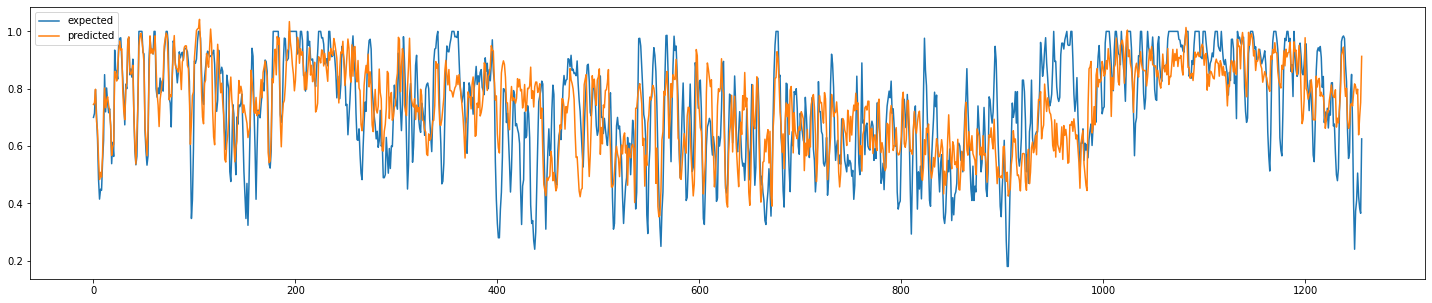

In [11]:
mb = learner.metabase.metabase

y_true = mb['precision']
y_pred = mb['predicted']
x = range(len(y_true))

fig = plt.figure(figsize=(25, 5))
plt.plot(x, y_true, label="expected")
plt.plot(x, y_pred, label="predicted")
plt.legend(loc="upper left")

# Save metadata

In [12]:
mb.to_csv(f"metabases/{FILE_NAME}.csv", index=False)

In [13]:
with open(f"models/{FILE_NAME}.pickle", "wb") as handle:
    pickle.dump(learner.meta_model.model, handle, protocol=pickle.HIGHEST_PROTOCOL)